In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import cv2
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image 

In [2]:
#Only need 9 classes as Sudoku does not utilize 0
path_name = r"C:\Users\atcut\Documents\ML_Proj\Digits"
data = os.listdir(path_name)
data_X = []     
data_y = []  
classes = len(data)

for i in range (1, classes+1):
    data_list = os.listdir(path_name + "\\" +str(i))
    for j in data_list:
        pic = cv2.imread(path_name +"\\"+str(i)+"\\"+j)
        pic = cv2.resize(pic,(32,32))
        data_X.append(pic)
        data_y.append(i)

if len(data_X) == len(data_y) :
    print("Total Dataponits = ",len(data_X))

# Labels and images
data_X = np.array(data_X)
data_y = np.array(data_y)

Total Dataponits =  9144


### Train-Test Split

In [3]:
train_X, test_X, train_y, test_y = train_test_split(data_X,data_y,test_size=0.1)
train_X, valid_X, train_y, valid_y = train_test_split(train_X,train_y,test_size=0.2)

print("Training Set Shape = ",train_X.shape)
print("Validation Set Shape = ",valid_X.shape)
print("Test Set Shape = ",test_X.shape)

Training Set Shape =  (6583, 32, 32, 3)
Validation Set Shape =  (1646, 32, 32, 3)
Test Set Shape =  (915, 32, 32, 3)


In [4]:
def Prep(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #making image grayscale
    img = cv2.equalizeHist(img) #Histogram equalization to enhance contrast
    img = img/255 #normalizing
    return img

train_X = np.array(list(map(Prep, train_X)))
test_X = np.array(list(map(Prep, test_X)))
valid_X= np.array(list(map(Prep, valid_X)))

#Reshaping the images
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], valid_X.shape[2],1)

#Augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
datagen.fit(train_X)

In [5]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
valid_y = to_categorical(valid_y)

#Note it creates 10 features as it goes from 0 to Highest Value (9) making it 10

### Model Building Using Tensorflow

In [6]:
#Creating a Neural Network

model = keras.Sequential()

model.add(keras.Input(shape= (32, 32, 1)))
model.add((Conv2D(60,(5,5),padding = 'Same' ,activation='relu')))
model.add((Conv2D(60, (5,5),padding="same",activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add((Conv2D(30, (3,3),padding="same", activation='relu')))
model.add((Conv2D(30, (3,3), padding="same", activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 30)     │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       960,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,081,490 (4.13 MB)

 Trainable params: 1,081,490 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#Compiling the model

BATCH_SIZE = 256
#optimizer = RMSprop(learning_rate=0.002, rho=0.9, epsilon = 1e-08)
model.compile(optimizer="adam" ,loss='categorical_crossentropy',metrics=['accuracy'])

#Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(datagen.flow(train_X, train_y, batch_size=BATCH_SIZE),
                              epochs = 30, validation_data = (valid_X, valid_y),
                              verbose = 2, callbacks = [early_stopping])

#(len(train_X)//32)

Epoch 1/30


C:\Users\atcut\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 - 8s - 302ms/step - accuracy: 0.2768 - loss: 1.9378 - val_accuracy: 0.8748 - val_loss: 0.5582
Epoch 2/30
26/26 - 6s - 223ms/step - accuracy: 0.7349 - loss: 0.7810 - val_accuracy: 0.9423 - val_loss: 0.1675
Epoch 3/30
26/26 - 6s - 220ms/step - accuracy: 0.8745 - loss: 0.3816 - val_accuracy: 0.9745 - val_loss: 0.0808
Epoch 4/30
26/26 - 6s - 219ms/step - accuracy: 0.9171 - loss: 0.2462 - val_accuracy: 0.9781 - val_loss: 0.0703
Epoch 5/30
26/26 - 6s - 227ms/step - accuracy: 0.9357 - loss: 0.2013 - val_accuracy: 0.9866 - val_loss: 0.0407
Epoch 6/30
26/26 - 6s - 217ms/step - accuracy: 0.9380 - loss: 0.1905 - val_accuracy: 0.9891 - val_loss: 0.0369
Epoch 7/30
26/26 - 6s - 216ms/step - accuracy: 0.9543 - loss: 0.1390 - val_accuracy: 0.9872 - val_loss: 0.0362
Epoch 8/30
26/26 - 6s - 222ms/step - accuracy: 0.9597 - loss: 0.1236 - val_accuracy: 0.9903 - val_loss: 0.0310
Epoch 9/30
26/26 - 6s - 224ms/step - accuracy: 0.9575 - loss: 0.1266 - val_accuracy: 0.9903 - val_loss: 0.0286
Epoch 10/30


In [8]:

score = model.evaluate(test_X, test_y, verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.015308800153434277
Test Accuracy = 0.9967213273048401


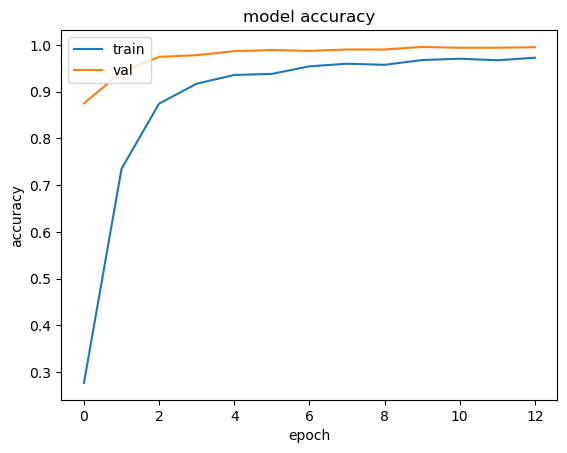

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

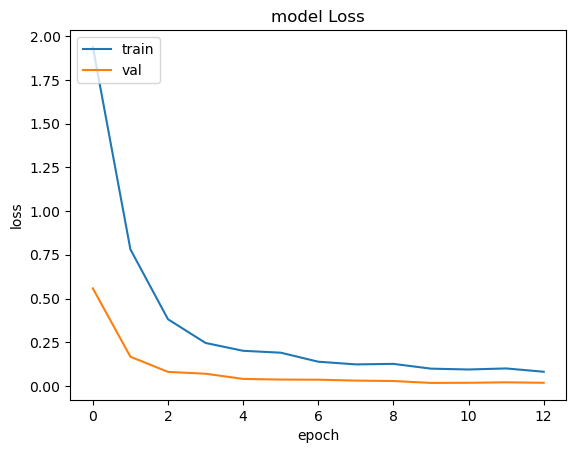

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:

#https://keras.io/guides/serialization_and_saving/
model.save("tf_digit_classifier_EX.keras")